In [53]:
import pandas as pd

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from pandas import DataFrame
from collections import OrderedDict 
import warnings

warnings.filterwarnings("ignore")

In [55]:
df = pd.read_csv('./fake reviews dataset.csv')

In [56]:
df = df.dropna()
df.count()

category    40432
rating      40432
label       40432
text_       40432
dtype: int64

In [57]:
df.category.value_counts()

Kindle_Store_5                  4730
Books_5                         4370
Pet_Supplies_5                  4254
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3946
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3848
Toys_and_Games_5                3794
Movies_and_TV_5                 3588
Name: category, dtype: int64

In [58]:
df.category.unique()

array(['Home_and_Kitchen_5', 'Sports_and_Outdoors_5', 'Electronics_5',
       'Movies_and_TV_5', 'Tools_and_Home_Improvement_5',
       'Pet_Supplies_5', 'Kindle_Store_5', 'Books_5', 'Toys_and_Games_5',
       'Clothing_Shoes_and_Jewelry_5'], dtype=object)

In [59]:
#df = df[df['text_'].apply(lambda x: len(x.split(' ')) >= 5)]

### Text Preprocessing 

In [60]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    
    # lower case
    sentence = sentence.lower()
    
    # remove special characters
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    
    # tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    
    # remove stopwords
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    
    # stemming and lemmatization
    #stem_words=[stemmer.stem(w) for w in filtered_words]
    stem_words = filtered_words
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    
    return " ".join(lemma_words)


# clean text
df['cleanText']=df['text_'].map(lambda s:preprocess(s)) 

### Make new Y label

In [61]:
def create_y(row):
    if row['label'] == 'CG':
        return 1
    else:
        return 0

In [62]:
df['new_label'] = df.apply(lambda row: create_y(row), axis=1)

In [63]:
df.head()

,category,rating,label,text_,cleanText,new_label
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",love well made sturdy comfortable love pretty,1
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",love great upgrade original mine couple year,1
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,pillow saved back love look feel pillow,1
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",missing information use great product price,1
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,nice set good quality set two month,1


## Get 5 categories model

### Split dataset and TF-IDF transform

In [70]:
df['cleanText'] = df['cleanText'].astype('str')

In [71]:
categories = ['Home_and_Kitchen_5', 'Electronics_5', 'Sports_and_Outdoors_5', 
              'Clothing_Shoes_and_Jewelry_5', 'Movies_and_TV_5']

In [72]:
transformers = []
models = []

for category in categories:
    
    # take each category data
    y = df[df['category']  == category]['new_label']
    x = df[df['category']  == category]['cleanText']
    x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.20)
    
    # perform tfidf transformation
    tfidf_vect = TfidfVectorizer()
    tfidf_train = tfidf_vect.fit_transform(x_train)
    tfidf_test = tfidf_vect.transform(x_test)
    
    # model training
    Adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=50, learning_rate=0.3, random_state=1)
    Adab.fit(tfidf_train, y_train)
    y_pred3 = Adab.predict(tfidf_test)
    
    
    # print the performance of the model
    print(category)
    acc_score = metrics.accuracy_score(y_test,y_pred3)
    auc_score = metrics.roc_auc_score(y_test,y_pred3)
    precision = metrics.precision_score(y_test, y_pred3)
    print(acc_score)
    print(auc_score)
    print(precision)
    print(' ')
    
    
    # make a transformer that fits on all data
    tfidf_transformer = TfidfVectorizer().fit(x)
    tfidf_all = tfidf_transformer.transform(x)
    y_all = y
    
    # make a model that is trained on all data
    Adab_final = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=50, learning_rate=0.3, random_state=1)
    Adab_final.fit(tfidf_all, y_all)
    
    # append to list
    transformers.append(tfidf_transformer)
    models.append(Adab_final)
    

Home_and_Kitchen_5
0.8066502463054187
0.806615220345564
0.8038740920096852
 
Electronics_5
0.7832080200501254
0.7832339805398343
0.7878787878787878
 
Sports_and_Outdoors_5
0.8177215189873418
0.8177296645964325
0.8202531645569621
 
Clothing_Shoes_and_Jewelry_5
0.8233766233766234
0.8238268171508802
0.8430851063829787
 
Movies_and_TV_5
0.7938718662952646
0.7939083537034881
0.7883008356545961
 


## Label each amazon file

In [73]:
import json

final_df_lst = []


categories = ['Home_and_Kitchen_2018', 'Electronics_2018', 'Sports_and_Outdoors_2018', 
              'Clothing_Shoes_and_Jewelry_2018', 'Movies_and_TV_2018']


for category in categories:
    
    idx = categories.index(category)
    
    path = './' + category + '.json'
    #file = open(path, 'r', encoding='utf-8')
    #reviews = []
    
    #for line in file.readlines():
    #    dic = json.loads(line)
    #    if dic['reviewTime'][6:11] == '2018':
    #        reviews.append(dic['reviewText'])
    
    # open json and take corresponding field
    reviews = []
    with open(path, 'r') as file:
        contents = json.loads(file.read())
    file.close()

    cnt = 0
    for element in contents:
        try:
            if len(element['reviewText'].split(' ')) >= 1:
                reviews.append(element['reviewText'])
        except:
            cnt += 1
    
    #print(len(reviews))
    # convert to dataframe
    df_a = pd.DataFrame(reviews)
    df_a.columns = ['review_text']
    df_a['category'] = category
    
    # randomly sample 3000 rows and clean text
    df_a = df_a.sample(n = 1000, replace=False)
    df_a['cleanText']=df_a['review_text'].map(lambda s:preprocess(s)) 
    
    # transform the data and get prediction
    transformer_a = transformers[idx]
    x_a = df_a['cleanText']
    tfidf_a = transformer_a.transform(x_a)
    
    model_a = models[idx]
    pred_a = model_a.predict(tfidf_a)
    df_a['label'] = pred_a
    
    # see the distribution of fake review in each category
    dict_ = df_a['label'].value_counts().to_dict()
    percent = dict_[1] / (dict_[0] + dict_[1])
    print(category)
    print('{:.1%}'.format(percent))
    print(' ')
    
    final_df_lst.append(df_a)

Home_and_Kitchen_2018
14.2%
 
Electronics_2018
20.0%
 
Sports_and_Outdoors_2018
21.1%
 
Clothing_Shoes_and_Jewelry_2018
16.2%
 
Movies_and_TV_2018
30.8%
 


In [18]:
df_final = pd.concat(final_df_lst)

In [19]:
df_final.head()

,review_text,category,cleanText,label
425216,In the pic it looks like the bows are matching...,Home_and_Kitchen_2018,pic look like bow matching set exception color...,0
576441,Cute but the molds are much larger than expect...,Home_and_Kitchen_2018,cute mold much larger expected mwan huge plan ...,0
23548,I've purchased several of these heaters and th...,Home_and_Kitchen_2018,purchased several heater great office yet one ...,0
546309,This ashtray is perfect for being in a windy c...,Home_and_Kitchen_2018,ashtray perfect windy city eliminates hot ash ...,0
380588,We used these for our outdoor kitchen countert...,Home_and_Kitchen_2018,used outdoor kitchen countertop lool amazing,0


In [51]:
categories = ['Home_and_Kitchen_2018', 'Electronics_2018', 'Sports_and_Outdoors_2018', 
              'Clothing_Shoes_and_Jewelry_2018', 'Movies_and_TV_2018']


for category in categories:
    
    # get corresponding data
    df_0 = df_final[(df_final['category'] == category) & (df_final['label'] == 0)] 
    df_1 = df_final[(df_final['category'] == category) & (df_final['label'] == 1)] 
    
    # merge to one string
    text_0 = ''
    for t in df_0['cleanText'].values:
        text_0 = text_0 + ' ' + t
        
    
    text_1 = ''
    for tt in df_1['cleanText'].values:
        text_1 = text_1 + ' ' + tt
    
    
    # write to txt file
    file0 = './txt_file/' + category + '_real.txt'
    file1 = './txt_file/' + category + '_fake.txt'
    
    with open(file0, "w") as text_file:
        text_file.write(text_0)
    text_file.close
    
    with open(file1, "w") as text_file:
        text_file.write(text_1)
    text_file.close

In [52]:
# save labelled amazon review data to csv file
df_final.to_csv('./amazon_with_label.csv', index=None)

### Hyperparameter tuning

In [13]:
# auc = 0.826   max_depth = 5   n_estimators = 70   learning rate = 0.5
# auc = 0.849   max_depth = 3   n_estimators = 200  learning rate = 0.5

In [53]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [54]:
with open('./txt_file/Movies_and_TV_2018_real.txt', "r") as text_file:
    content = text_file.readlines()
text_file.close()
content = ''.join(content)

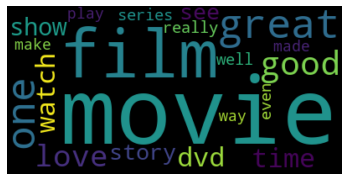

In [55]:
# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=20).generate(content)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [56]:
with open('./txt_file/Movies_and_TV_2018_fake.txt', "r") as text_file:
    content = text_file.readlines()
text_file.close()
content = ''.join(content)

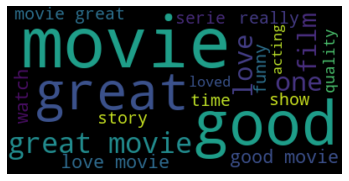

In [57]:
# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=20).generate(content)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [2]:
import json

In [17]:
categories = ['Home_and_Kitchen', 'Electronics', 'Sports_and_Outdoors', 
              'Clothing_Shoes_and_Jewelry', 'Movies_and_TV']


cat = 'Sports_and_Outdoors'
path = './' + cat + '.json'



file = open(path, 'r', encoding='utf-8')
to_be_saved = []
cnt = 0

for line in file.readlines():
    cnt += 1
    dic = json.loads(line)
    if dic['reviewTime'][6:11] == '2017':
        to_be_saved.append(dic)
    
    if cnt % 10000 == 0:
        print(cnt)

file.close()

with open(cat + '_2017.json', "w") as output_data:
    output_data.write(json.dumps(to_be_saved, indent=2))

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
1390

10360000
10370000
10380000
10390000
10400000
10410000
10420000
10430000
10440000
10450000
10460000
10470000
10480000
10490000
10500000
10510000
10520000
10530000
10540000
10550000
10560000
10570000
10580000
10590000
10600000
10610000
10620000
10630000
10640000
10650000
10660000
10670000
10680000
10690000
10700000
10710000
10720000
10730000
10740000
10750000
10760000
10770000
10780000
10790000
10800000
10810000
10820000
10830000
10840000
10850000
10860000
10870000
10880000
10890000
10900000
10910000
10920000
10930000
10940000
10950000
10960000
10970000
10980000
10990000
11000000
11010000
11020000
11030000
11040000
11050000
11060000
11070000
11080000
11090000
11100000
11110000
11120000
11130000
11140000
11150000
11160000
11170000
11180000
11190000
11200000
11210000
11220000
11230000
11240000
11250000
11260000
11270000
11280000
11290000
11300000
11310000
11320000
11330000
11340000
11350000
11360000
11370000
11380000
11390000
11400000
11410000
11420000
11430000
11440000
11450000
11460000
1